In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ray.tune.schedulers.async_hyperband import ASHAScheduler
from ray.tune.suggest.suggestion import ConcurrencyLimiter
from experimental.experiment import Experiment
from experimental.experiment_params import ExperimentParams
from datasets.activelearningdataset import DatasetName
from utils.parser import parse_dataset, parse_model, parse_training, parse_method
import ray
from ray import tune
from ray.tune.suggest.dragonfly import DragonflySearch
from argparse import Namespace
import argparse
import uuid

/home/john/.conda/envs/active_learning/lib/python3.9/site-packages/dragonfly/utils/oper_utils.py:30: UserWarning: cannot import name 'direct' from 'dragonfly.utils.direct_fortran' (/home/john/.conda/envs/active_learning/lib/python3.9/site-packages/dragonfly/utils/direct_fortran/__init__.py)
Could not import Fortran direct library. Dragonfly can still be used, but might be slightly slower. To get rid of this warning, install a numpy compatible Fortran compiler (e.g. gfortran) and the python-dev package and reinstall Dragonfly.
  warn('%s\n%s'%(e, fortran_err_msg))


In [3]:
var_opt = 0.003
lr = 0.003
method = "batchbald"
batch_size = 64
dropout = 0.0
n_inducing_points = 10
path = "./data"
starting_size = 2
num_aquisitions = 5
coeff = 9.0
args = Namespace(
            data_path=path,
            aquisition_size=7, batch_size=batch_size, dataset=DatasetName.mnist, description='ray-vduq', dropout=dropout,
            epochs=1, initial_per_class=starting_size, smoke_test=True, var_reduction=False, lr=lr, method=method, use_progress=False, model='vduq', model_index=0, var_opt=var_opt, n_inducing_points=n_inducing_points,
            num_repetitions=1, name='vduq_bb_tuning', num_aquisitions=num_aquisitions, power_iter=1, spectral_norm=True, coeff=coeff)



In [4]:
# Create the active learning method
dataset_params = parse_dataset(args)
method_params = parse_method(args)
model_params = parse_model(args)
training_params = parse_training(args)

expr_config = ExperimentParams(
        training_params=training_params,
        model_params=model_params,
        method_params=method_params,
        dataset_params=dataset_params
)

expr = Experiment(
    args.name,
    args.description,
    expr_config
)

In [5]:
import torch.autograd.profiler as profiler
import time
import tracemalloc
import gc
import sys
import torch
from experimental.driver import Driver
from ignite.contrib.handlers.tensorboard_logger import TensorboardLogger


In [6]:
ts = time.time()
iteration = 0
name = expr.name + "_" + str(iteration) + str(ts)
tb_logger = TensorboardLogger(flush_secs=1, log_dir="logs/" + name)
model = Driver.train(name, iteration, expr.training_params, expr.model, expr.dataset, tb_logger)

{'loss': 2.2654908025075517}
Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 
{'accuracy': 0.140625, 'loss': 2.6230788230895996}


In [7]:
from utils.utils import get_pool
from utils.typing import TensorType
from uncertainty.multivariate_normal import MultitaskMultivariateNormalType
from uncertainty.mvn_joint_entropy import CustomEntropy, GPCEntropy, Rank2Next
from uncertainty.estimator_entropy import ExactJointEntropyEstimator, SampledJointEntropyEstimator, BBReduxJointEntropyEstimator,  Sampling
from tqdm.notebook import tqdm 

import copy


In [ ]:
model_wrapper=model
candidate_indices = []
candidate_scores = []


dataset= copy.deepcopy(expr.dataset)
inputs: TensorType["datapoints","channels","x","y"] = get_pool(dataset)
N = inputs.shape[0]
num_cat = 10
batch_size = 3
batch_size = min(batch_size, N)
pool: TensorType["datapoints","num_features"] = model_wrapper.get_features(inputs)

model_wrapper.model.eval()

features_expanded: TensorType["N", 1, "num_features"] = pool[:,None,:]
ind_dists: MultitaskMultivariateNormalType = model_wrapper.get_gp_output(features_expanded)




In [ ]:
conditional_entropies_N: TensorType["datapoints"] = GPCEntropy.compute_conditional_entropy_mvn(ind_dists, model_wrapper.likelihood, 5000).cpu()

joint_entropy_class: GPCEntropy = CustomEntropy(model_wrapper.likelihood, Sampling(per_samples=1, batch_samples=6000), num_cat, N, ind_dists, BBReduxJointEntropyEstimator)
# joint_entropy_class: GPCEntropy = CustomEntropy(model_wrapper.likelihood, Sampling(per_samples=50, sum_samples=10, batch_samples=600), num_cat, N, ind_dists, SampledJointEntropyEstimator)

joint_entropy_class_: GPCEntropy = CustomEntropy(model_wrapper.likelihood, Sampling(batch_samples=6000), num_cat, N, ind_dists, ExactJointEntropyEstimator)

Aquiring:   0%|          | 0/3 [00:00<?, ?it/s]



GP:   0%|          | 0/80 [00:00<?, ?it/s]

GP: 100%|██████████| 80/80 [00:00<00:00, 262.96it/s]

                                                    

BBRedux Batch:   0%|          | 0/78 [00:00<?, ?it/s]


SampledJointEntropy.compute_batch:   0%|          | 0/78 [00:00<?, ?it/s]


SampledJointEntropy.compute_batch: 100%|██████████| 78/78 [00:16<00:00,  4.74it/s]


                                                                                  

                                                     

Exact Batch:   0%|          | 0/78 [00:00<?, ?it/s]

Exact Batch:   5%|▌         | 4/78 [00:00<00:01, 38.91it/s][]


Exact Batch:  12%|█▏        | 9/78 [00:00<00:01, 39.66it/s]

Exact Batch:  17%|█▋        | 13/78 [00:00<00:01, 39.57it/s]

Exact Batch:  23%|██▎       | 18/78 [00:00<00:01, 40.65it/s]

Exact Batch:  29%|██▉       | 23/78 [00:00<00:01, 40.77it/s]

Exact Batch:  36%|███▌      | 28/78 [00:00<00:01, 40.63it/s]

Exact Batch:  42%|████▏     | 33/78 [00:00<00:01, 40.35it/s]

Ex

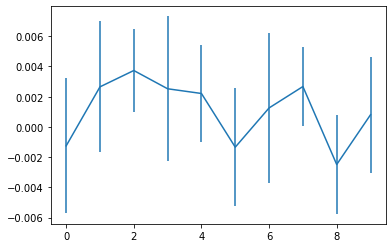

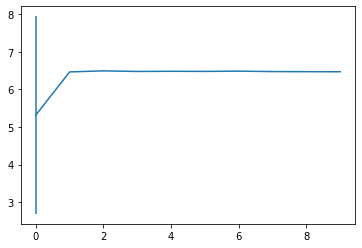

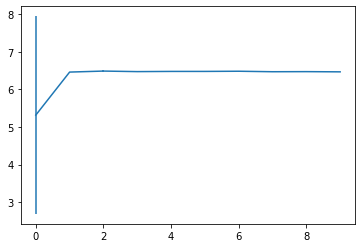



GP:   0%|          | 0/80 [00:00<?, ?it/s]

GP: 100%|██████████| 80/80 [00:00<00:00, 260.37it/s]

                                                    

BBRedux Batch:   0%|          | 0/77 [00:00<?, ?it/s]


SampledJointEntropy.compute_batch:   0%|          | 0/77 [00:00<?, ?it/s]


SampledJointEntropy.compute_batch: 100%|██████████| 77/77 [00:18<00:00,  4.09it/s]


                                                                                  

                                                     

Exact Batch:   0%|          | 0/77 [00:00<?, ?it/s][11]


Exact Batch:   1%|▏         | 1/77 [00:00<00:22,  3.44it/s]

Exact Batch:   3%|▎         | 2/77 [00:00<00:20,  3.72it/s]

Exact Batch:   4%|▍         | 3/77 [00:00<00:20,  3.67it/s]

Exact Batch:   5%|▌         | 4/77 [00:01<00:19,  3.76it/s]

Exact Batch:   6%|▋         | 5/77 [00:01<00:18,  3.86it/s]

Exact Batch:   8%|▊         | 6/77 [00:01<00:19,  3.70it/s]

Exact Batch:   9%|▉         | 7/77 [00:01<00:19,  3.53it/s]

Exact

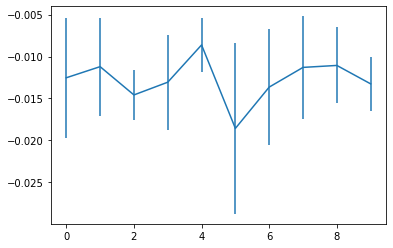

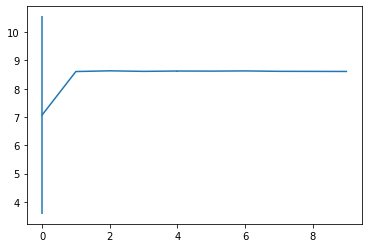

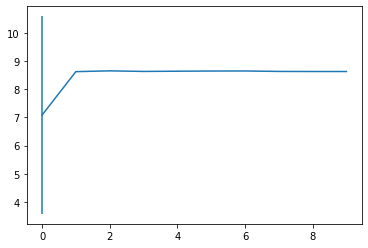



GP:   0%|          | 0/80 [00:00<?, ?it/s]

GP: 100%|██████████| 80/80 [00:00<00:00, 230.02it/s]

                                                    

BBRedux Batch:   0%|          | 0/76 [00:00<?, ?it/s]

In [25]:
from batchbald_redux.batchbald import CandidateBatch, get_batchbald_batch
from methods.method import UncertainMethod, Method

import numpy as np
import matplotlib.pyplot as plt
current_aquisition = 0
candidate_indices = [] 
candidate_scores = []
for i in tqdm(range(batch_size), desc="Aquiring", leave=False):
    # First we compute the joint distribution of each of the datapoints with the current aquisition
    # We first calculate the aquisition by itself first.

    joint_entropy_result: TensorType["datapoints"] = torch.empty(N, dtype=torch.double)

    previous_aquisition: int = candidate_indices[-1] if i > 0 else 0 # When we don't have any candiates it doesn't matter
    
    expanded_pool_features: TensorType["datapoints", 1, "num_features"] = pool[:, None, :]
    new_candidate_features: TensorType["datapoints", 1, "num_features"] = ((pool[previous_aquisition])[None, None, :]).expand(N, -1, -1)
    joint_features: TensorType["datapoints", 2, "num_features"] = torch.cat([new_candidate_features, expanded_pool_features], dim=1)
    dists: MultitaskMultivariateNormalType = model_wrapper.get_gp_output(joint_features)

    rank2dist: Rank2Next = Rank2Next(dists)
    if i > 0:
        joint_entropy_class.add_variables(rank2dist, previous_aquisition) #type: ignore # last point

    joint_entropy_result = joint_entropy_class.compute_batch(rank2dist)
    
    if i > 0:
        joint_entropy_class_.add_variables(rank2dist, previous_aquisition) #type: ignore # last point
        


    shared_conditinal_entropies = conditional_entropies_N[candidate_indices].sum()

    scores_N = joint_entropy_result.detach().clone().cpu()

    # scores_N -= conditional_entropies_N + shared_conditinal_entropies
    scores_N[candidate_indices] = -float("inf")

    candidate_score, candidate_index = scores_N.max(dim=0)
    print(candidate_indices)

    if True:
        joint_entropy_result_ = joint_entropy_class_.compute_batch(rank2dist) #type: ignore
        diff = joint_entropy_result - joint_entropy_result_
        pool_tensor = dataset.get_pool_tensor()
        scores_N_ = joint_entropy_result_ # - (conditional_entropies_N + shared_conditinal_entropies)
        scores_N_[candidate_indices] = -float("inf")
        # print(scores_N - scores_N_)
        candidate_score_, candidate_index_ = scores_N_.max(dim=0)
        print("Sampled")
        _, y = pool_tensor[candidate_index]
        print(y, candidate_score)
        print("Exact")
        _, y_ = pool_tensor[candidate_index_]
        print(y_, candidate_score_)
        print(candidate_indices)
        per_classes_idx = [ [] for i in range(num_cat)]

        for idx in range(0, len(pool_tensor)):
            _, y = pool_tensor[idx]
            if idx in candidate_indices:
                pass
            else:
                per_classes_idx[y].append(idx)

        # The difference between the 2 methods is minimum at the max value of the low memory
        difference = torch.flatten(diff)

        values = []
        for i in range(num_cat):
            values.append(torch.std_mean(difference[per_classes_idx[i]]))

        fig = plt.figure()
        x = np.arange(10)
        y = [b for a,b in values]
        yerr = [a for a,b in values]

        plt.errorbar(x, y, yerr=yerr, label='error')
        plt.show()

        values = []

        for i in range(num_cat):
            values.append(torch.std_mean(scores_N[per_classes_idx[i]]))

        fig = plt.figure()
        x = np.arange(10)
        y = [b for a,b in values]
        yerr = [a for a,b in values]

        plt.errorbar(x, y, yerr=yerr, label='error')
        plt.show()

        values = []

        for i in range(num_cat):
            values.append(torch.std_mean(scores_N_[per_classes_idx[i]]))

        fig = plt.figure()
        x = np.arange(10)
        y = [b for a,b in values]
        yerr = [a for a,b in values]

        plt.errorbar(x, y, yerr=yerr, label='error')
        plt.show()
    
    candidate_indices.append(candidate_index.item())
    candidate_scores.append(candidate_score.item())

batch = CandidateBatch(candidate_scores, candidate_indices)
print(batch)
